<a target="_blank" href="https://colab.research.google.com/github/tomginsberg/stimdx/blob/main/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# stimdx

This notebook demonstrates the `stimdx` dynamic circuit framework. It allows mixing static Stim blocks with Python-controlled branching and looping.

## Setup

In [ ]:
!pip install git+https://github.com/tomginsberg/stimdx.git qldpc

In [2]:
import stim
from stimdx import Circuit, LastMeas
from stimdx import context as ctx
from rich.panel import Panel
from rich import print


def print_circuit(circ):
    print(Panel(f"{circ}"))


def print_samples(samples):
    print(["".join(map(lambda x: "1" if x else "0", s)) for s in samples])

## Example 0: Basic Control Flow

- Prepare 2 random bits
- Flip bit one if parity is odd

In [3]:
circ = Circuit("H 0 1\nM 0 1")
# ctx is a proxy object that allows building expressions
# from the measurement record using logical operators
# ctx.rec is a symbol for the measurement record
circ.conditional(body="X 0", cond=ctx.rec(-1) ^ ctx.rec(-2))
circ.block("M 0 1")
print_circuit(circ)


sampler = circ.compile_sampler(seed=0)
samples = sampler.sample(shots=4)
print_samples(samples)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ StimBlock:                                                                                                      │
│   H 0 1                                                                                                         │
│   M 0 1                                                                                                         │
│ If (rec(-1) ^ rec(-2)):                                                                                         │
│   StimBlock:                                                                                                    │
│     X 0                                                                                                         │
│ StimBlock:                                                                                                      │
│   M 0 1                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

['1000', '1111', '0111', '1000']

In [4]:
circ = Circuit("H 0 1\nM 0 1")
# one level lower, we can use the runtime context object directly
circ.conditional(body="X 0", cond=lambda x: (x.meas_record[-1] ^ x.meas_record[-2]))
circ.block("M 0 1")
print_circuit(circ)


sampler = circ.compile_sampler(seed=0)
samples = sampler.sample(shots=4)
print_samples(samples)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ StimBlock:                                                                                                      │
│   H 0 1                                                                                                         │
│   M 0 1                                                                                                         │
│ If <function <lambda> at 0x79cff11b4360>:                                                                       │
│   StimBlock:                                                                                                    │
│     X 0                                                                                                         │
│ StimBlock:                                                                                                      │
│   M 0 1                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

['1000', '1111', '0111', '1000']

Instead we could non destructively measure the parity onto a third qubit

In [5]:
circ = Circuit("H 0 1\nCX 0 2 1 2\nM 2")
circ.conditional(body="X 0", cond=ctx.rec(-1))
circ.block("M 0 1")
print_circuit(circ)


sampler = circ.compile_sampler(seed=0)
samples = sampler.sample(shots=4)
print_samples(samples)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ StimBlock:                                                                                                      │
│   H 0 1                                                                                                         │
│   CX 0 2 1 2                                                                                                    │
│   M 2                                                                                                           │
│ If rec(-1):                                                                                                     │
│   StimBlock:                                                                                                    │
│     X 0                                                                                                         │
│ StimBlock:                                                                                                      │
│   M 0 1                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

['100', '111', '011', '100']

## Example 1: Repeat-Until-Success (RUS)

This circuit attempts an operation that has a probabilistic success. It repeats until the desired outcome is measured.

Scenario: We want to prepare a '0' state, but our noise channel flips it to '1' with 50% probability. We check and retry if we get '1'.

In [6]:
def build_rus_circuit():
    circ = Circuit()

    # Define the body of the loop
    # In a real RUS, this would be a probabilistic gate sequence.
    # Here we simulate a coin flip with H + Measure.
    trial_step_circ = Circuit()

    trial_block = stim.Circuit()
    trial_block.append("R", 0)  # Reset to clean state
    trial_block.append("H", 0)
    trial_block.append("M", 0)
    trial_step_circ.block(trial_block)

    # Add the loop to the main circuit
    # We want to STOP if we measure 0. So we CONTINUE while measurement is 1 (True).
    circ.do_while(body=trial_step_circ, cond=ctx.rec(-1))
    # Could also use this convenience for indexing directly into the last block
    # cond=lambda ctx: ctx.last_block_meas[0]

    return circ


rus_circ = build_rus_circuit()
print_circuit(rus_circ)
sampler = rus_circ.compile_sampler(seed=42)
samples = sampler.sample(shots=5)

print_samples(samples)
# Note: The output length varies! Each '1' is a failed attempt, ending in '0'.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Do:                                                                                                             │
│   StimBlock:                                                                                                    │
│     R 0                                                                                                         │
│     H 0                                                                                                         │
│     M 0                                                                                                         │
│ While rec(-1)                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

['1111111110', '10', '11110', '111111110', '110']

## Example 2: Fault-Tolerant Steane Code Prep

This example reproduces the logic of a Fault-Tolerant Steane code preparation with post-selection. 
We implement it as a Repeat-Until-Success loop, guaranteeing a valid state preparation.

![](https://mqt.readthedocs.io/projects/qecc/en/latest/_images/381e43e5a9eff8d14d9112dc0ee131c9d54db9e54271077f9f7a94dc8641c383.svg)

In [95]:
from qldpc.circuits import DepolarizingNoiseModel
from galois import GF
import numpy as np

# Steane Z-parity-check matrix over GF(2) (3x7)
stean_parity = GF(2)(
    [
        [0, 0, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [1, 0, 1, 0, 1, 0, 1],
    ]
)

# 1. Define the Steane Code Preparation Block
def build_steane_block(noisy=True, noise_rate=1e-3, add_parity_check=True):
    c = stim.Circuit()

    # Data qubits: 0-6. Ancilla: 7
    data_qubits = list(range(7))
    ancilla = 7

    # Reset all
    c.append("R", data_qubits + [ancilla])

    # Non-FT Zero Prep
    plus_ids = [0, 1, 5]
    c.append("H", plus_ids)

    cx_pairs = [(0, 2), (5, 3), (1, 5), (0, 6), (1, 2), (5, 4), (2, 3), (5, 6)]
    for ctrl, targ in cx_pairs:
        c.append("CNOT", [ctrl, targ])

    # FT Verification (Flag check)
    # Verifies the stabilizer weights using an ancilla
    if add_parity_check:
        flags = [2, 3, 6]
        for f in flags:
            c.append("CNOT", [f, ancilla])

        # Measure ancilla to check for errors
        c.append("M", ancilla)

    if noisy:
        nm = DepolarizingNoiseModel(p=noise_rate)
        return nm.noisy_circuit(c)
    return c


def error_rate(samples) -> int:
    s = GF(2)([x[-7:] for x in samples])
    syndromes_vecs = (s @ stean_parity.T)
    syndromes =  np.all(syndromes_vecs == False, axis=1)
    parities = (s @ GF(2)([[1] * 7]).T == 0).flatten()
    # sucess criteria is syndromes is 0 and parity is 0
    # or syndrme is non-zero and parity is 1 (correctable error)
    success = ((syndromes) & (parities)) | ((~syndromes) & (~parities))
    return 1 - success.sum() / len(s)


# 2. Build the Dynamic Circuit (RUS)
def ft_stean_block(noisy=True, show=False, shots=10000, noise_rate=1e-3, use_rus=True):
    steane_gen = Circuit()
    attempt_block = build_steane_block(noisy=noisy, noise_rate=noise_rate, add_parity_check=use_rus)

    # Create a sub-circuit for the body to be repeated

    if use_rus:
        body = Circuit(attempt_block)
        steane_gen.do_while(
            body=body,
            cond=ctx.rec(
                -1
            ),  # The ancilla measurement is the last (and only) meas in the block.
            # If 1 (True), we restart.
        )
    else:
        steane_gen.block(attempt_block)

    # 3. Final Parity Check Calculation (in software/classical post-processing)
    # In the simulation, we just measure all data qubits to verify the state.
    final_meas = stim.Circuit()
    final_meas.append("M", list(range(7)))
    steane_gen.block(final_meas)
    if show:
        print_circuit(steane_gen)

    # 4. Sample and Compute Parity
    sampler = steane_gen.compile_sampler()
    samples = sampler.sample(shots=shots)

    er = error_rate(samples)
    rep_count = np.array([len(x) - 7 for x in samples])

    return er, rep_count


er, rep_count = ft_stean_block(show=True, noisy=True, use_rus=True)
print(
        f"Logical Error Rate: {er:.2%}",
        f'Mean Repetitions: {rep_count.mean():.2f}',
        sep="\n",
    )

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Do:                                                                                                             │
│   StimBlock:                                                                                                    │
│     R 0 1 2 3 4 5 6 7                                                                                           │
│     X_ERROR(0.001) 0 1 2 3 4 5 6 7                                                                              │
│     TICK                                                                                                        │
│     H 0 1 5                                                                                                     │
│     DEPOLARIZE1(0.001) 0 1 5                                                                                    │
│     TICK                                                                                                        │
│     CX 0 2 5 3                                                                                                  │
│     DEPOLARIZE2(0.001) 0 2 5 3                                                                                  │
│     TICK                                                                                                        │
│     CX 1 5 0 6                                                                                                  │
│     DEPOLARIZE2(0.001) 1 5 0 6                                                                                  │
│     TICK                                                                                                        │
│     CX 1 2 5 4                                                                                                  │
│     DEPOLARIZE2(0.001) 1 2 5 4                                                                                  │
│     TICK                                                                                                        │
│     CX 2 3 5 6                                                                                                  │
│     DEPOLARIZE2(0.001) 2 3 5 6                                                                                  │
│     TICK                                                                                                        │
│     CX 2 7                                                                                                      │
│     DEPOLARIZE2(0.001) 2 7                                                                                      │
│     TICK                                                                                                        │
│     CX 3 7                                                                                                      │
│     DEPOLARIZE2(0.001) 3 7                                                                                      │
│     TICK                                                                                                        │
│     CX 6 7                                                                                                      │
│     DEPOLARIZE2(0.001) 6 7                                                                                      │
│     TICK                                                                                                        │
│     M(0.001) 7                                                                                                  │
│ While rec(-1)                                                                                                   │
│ StimBlock:                                                                                                      │
│   M 0 1 2 3 4 5 6                                                                                               │
╰───────────────────────────────────────────────────────

Logical Error Rate: 0.52%
Mean Repetitions: 2.01

Compute logical error rate and mean repetition count vs physical depolarizing error

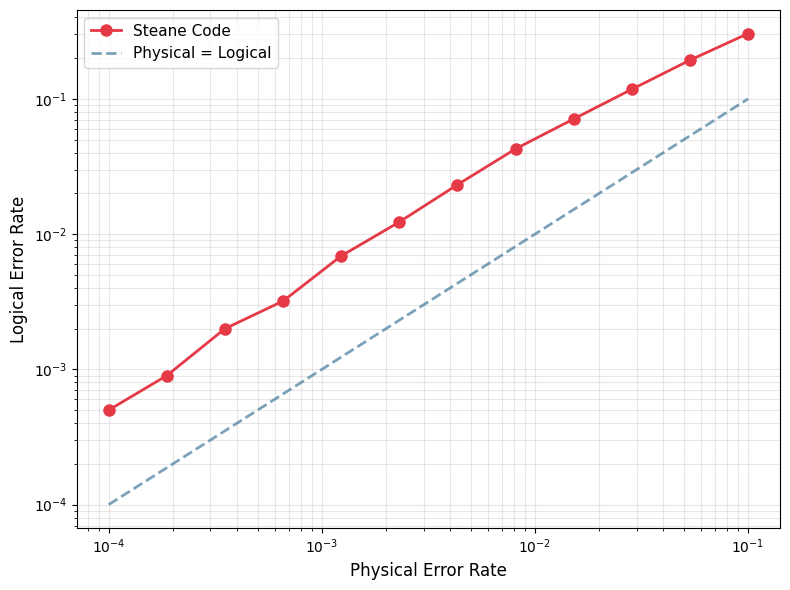

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Sweep physical error rates
physical_rates = np.logspace(-4, -1, 12)
logical_rates = []
for p in physical_rates:
    lr, _ = ft_stean_block(noisy=True, noise_rate=p, shots=10000)
    logical_rates.append(lr)

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(physical_rates, logical_rates, 'o-', color='#e63946', linewidth=2, markersize=8, label='Steane Code')
plt.loglog(physical_rates, physical_rates, '--', color='#457b9d', linewidth=2, alpha=0.7, label='Physical = Logical')
plt.xlabel('Physical Error Rate', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()